In [1]:
# handle bugs in some docker container: 'pip install -e .'  doesn't work 
try:
    import Flamingo
except ModuleNotFoundError:
    import sys 
    sys.path.append('..')
    import Flamingo
lang_encoder_path = "facebook/opt-125m"
tokenizer_path = lang_encoder_path
cache_dir = None 
model_config = dict(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path=lang_encoder_path,
    tokenizer_path=tokenizer_path,
    cross_attn_every_n_layers=1,
    cache_dir = cache_dir,
    lora_tuning=False,
    decoupled=True  
)

import torch
from Flamingo.lora_tuning import create_model_and_transforms 
from Flamingo.models.batchprocessor import DecoupledFlamingoBatchProcessor
from Flamingo.datasets.gtsrb import classes
from Flamingo.config.baseline import dataset_config
from Flamingo.datasets import build_dataset
from Flamingo.inference.vis import show_pred_with_gt
from Flamingo.inference import post_process
import pandas as pd 
import pdb
import re

[2024-01-12 13:13:10,554] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# build model, image processor and tokenizer
model, image_processor, tokenizer = create_model_and_transforms(
    **model_config
)
print("Load state dict:")
state_dict = torch.load("/root/yunzhi/flamingo_retrieval/retrieval/work_dir/100/weight.pth")
keys1 = model.lang_encoder.gated_cross_attn_layers.load_state_dict(state_dict, strict=False)
keys2 = model.perceiver.load_state_dict(state_dict, strict=False)
dataset = build_dataset(
    dataset_config=dataset_config,
    vis_processor=image_processor,
    tokenizer=tokenizer)
model = model.to(device="cuda:2", dtype=torch.bfloat16)
model.eval()
batch_processor = DecoupledFlamingoBatchProcessor(cast_type='bf16', tokenizer=tokenizer)

Flamingo will use single GPU or CPU

[@rank-1|create Flamingo] create vision_encoder and image_processor from open_clip

[@rank-1|create Flamingo] create text_tokenizer

[@rank-1|create Flamingo] create LLM from  facebook/opt-125m

[@rank-1|create Flamingo] create Flamingo with cross_attn_every_n_layers= 1

[@rank-1|create Flamingo] load checkpoint.pt from huggingface

[@rank-1|create Flamingo] Freeze all parameters

[@rank-1|create Flamingo] LoRa tuning mode:  False

[@rank-1|set requires_grad] No LoRA adaptor, unfrozen the gate cross attention layer

[@rank-1|set requires_grad] unfrozen perceiver layer

Flamingo model initialized with 171MB trainable parameters

Load state dict:


In [4]:
cats = [classes[k] for k in classes]

In [3]:
data = dataset.random_input25()  


before post process: ["Output:Roundabout mandatory�I'm a big fan of the roundabout mandatory\x7fI'm a", "Output:Speed limit (100km/h) guiActiveUnI'm not sure if I should be able to", 'Output:End of speed limit (80km/h)', "Output:Go straight or right�I'm a big fan of the right right�I love how", "Output:Speed limit (70km/h)<mask>I'm not sure if I'm going to be", "Output:Road work guiActiveUnI'm not sure how to drive here\nRoad work\nRoad work\nRoad", 'Output:Speed limit (50km/h)', "Output:Ahead only\x7fI'm a fan of a a head only�I'm a big", "Output:Ahead only\x7fI'm a fan of a head only\x7fI'm a fan of", 'Output:Dangerous curve left guiActiveUnDangerous curve left\nDangerous curve left\nD', 'Output:Speed limit (100km/h)', "Output:Slippery road guiActiveUnI'm a big fan of the road road\x7fI'm a big", "Output:Road work guiActiveUnI'm not sure if I'm going to school or work in the winter\n", 'Output:Speed limit (80km/h)', "Output:Speed limit (120km/h)�I'm not sure if I'm going to be", 'Out

NameError: name 'cats' is not defined

In [5]:
with torch.inference_mode():
    output = batch_processor(model=model, batch=data['vision_x'], mode='test',
            text_prompt="<image>Output:", num_beams=3, max_new_tokens=20)
    print("before post process:", output)
    output = post_process(output, cats=cats)
output

before post process: ["Output:Roundabout mandatory�I'm a big fan of the roundabout mandatory\x7fI'm a", "Output:Speed limit (100km/h) guiActiveUnI'm not sure if I should be able to", 'Output:End of speed limit (80km/h)', "Output:Go straight or right�I'm a big fan of the right right�I love how", "Output:Speed limit (70km/h)<mask>I'm not sure if I'm going to be", "Output:Road work guiActiveUnI'm not sure how to drive here\nRoad work\nRoad work\nRoad", 'Output:Speed limit (50km/h)', "Output:Ahead only\x7fI'm a fan of a a head only�I'm a big", "Output:Ahead only\x7fI'm a fan of a head only\x7fI'm a fan of", 'Output:Dangerous curve left guiActiveUnDangerous curve left\nDangerous curve left\nD', 'Output:Speed limit (100km/h)', "Output:Slippery road guiActiveUnI'm a big fan of the road road\x7fI'm a big", "Output:Road work guiActiveUnI'm not sure if I'm going to school or work in the winter\n", 'Output:Speed limit (80km/h)', "Output:Speed limit (120km/h)�I'm not sure if I'm going to be", 'Out

['Roundabout mandatory',
 'Speed limit (100km/h)',
 'End of speed limit (80km/h)',
 'Go straight or right',
 'Speed limit (70km/h)',
 'Road work',
 'Speed limit (50km/h)',
 'Ahead only',
 'Ahead only',
 'Dangerous curve left',
 'Speed limit (100km/h)',
 'Slippery road',
 'Road work',
 'Speed limit (80km/h)',
 'Speed limit (120km/h)',
 'Yield',
 'No passing',
 'Speed limit (50km/h)',
 'Ahead only',
 'Speed limit (80km/h)',
 'Go straight or left',
 'Bumpy road',
 'Go straight or right',
 'Yield',
 'Priority road']

In [6]:
# 查看显存占用
torch.cuda.memory_allocated() // (1024 * 1024),torch.cuda.max_memory_allocated() // (1024 * 1024)

(270, 270)

In [7]:
table = pd.DataFrame({
    "pred":output,
    "gt":data['labels']
})
table

,pred,gt
0,Roundabout mandatory,Roundabout mandatory
1,Speed limit (100km/h),Speed limit (100km/h)
2,End of speed limit (80km/h),End of speed limit (80km/h)
3,Go straight or right,Go straight or right
4,Speed limit (70km/h),Speed limit (70km/h)
5,Road work,Road work
6,Speed limit (50km/h),Speed limit (50km/h)
7,Ahead only,Ahead only
8,Ahead only,Ahead only
9,Dangerous curve left,Dangerous curve left


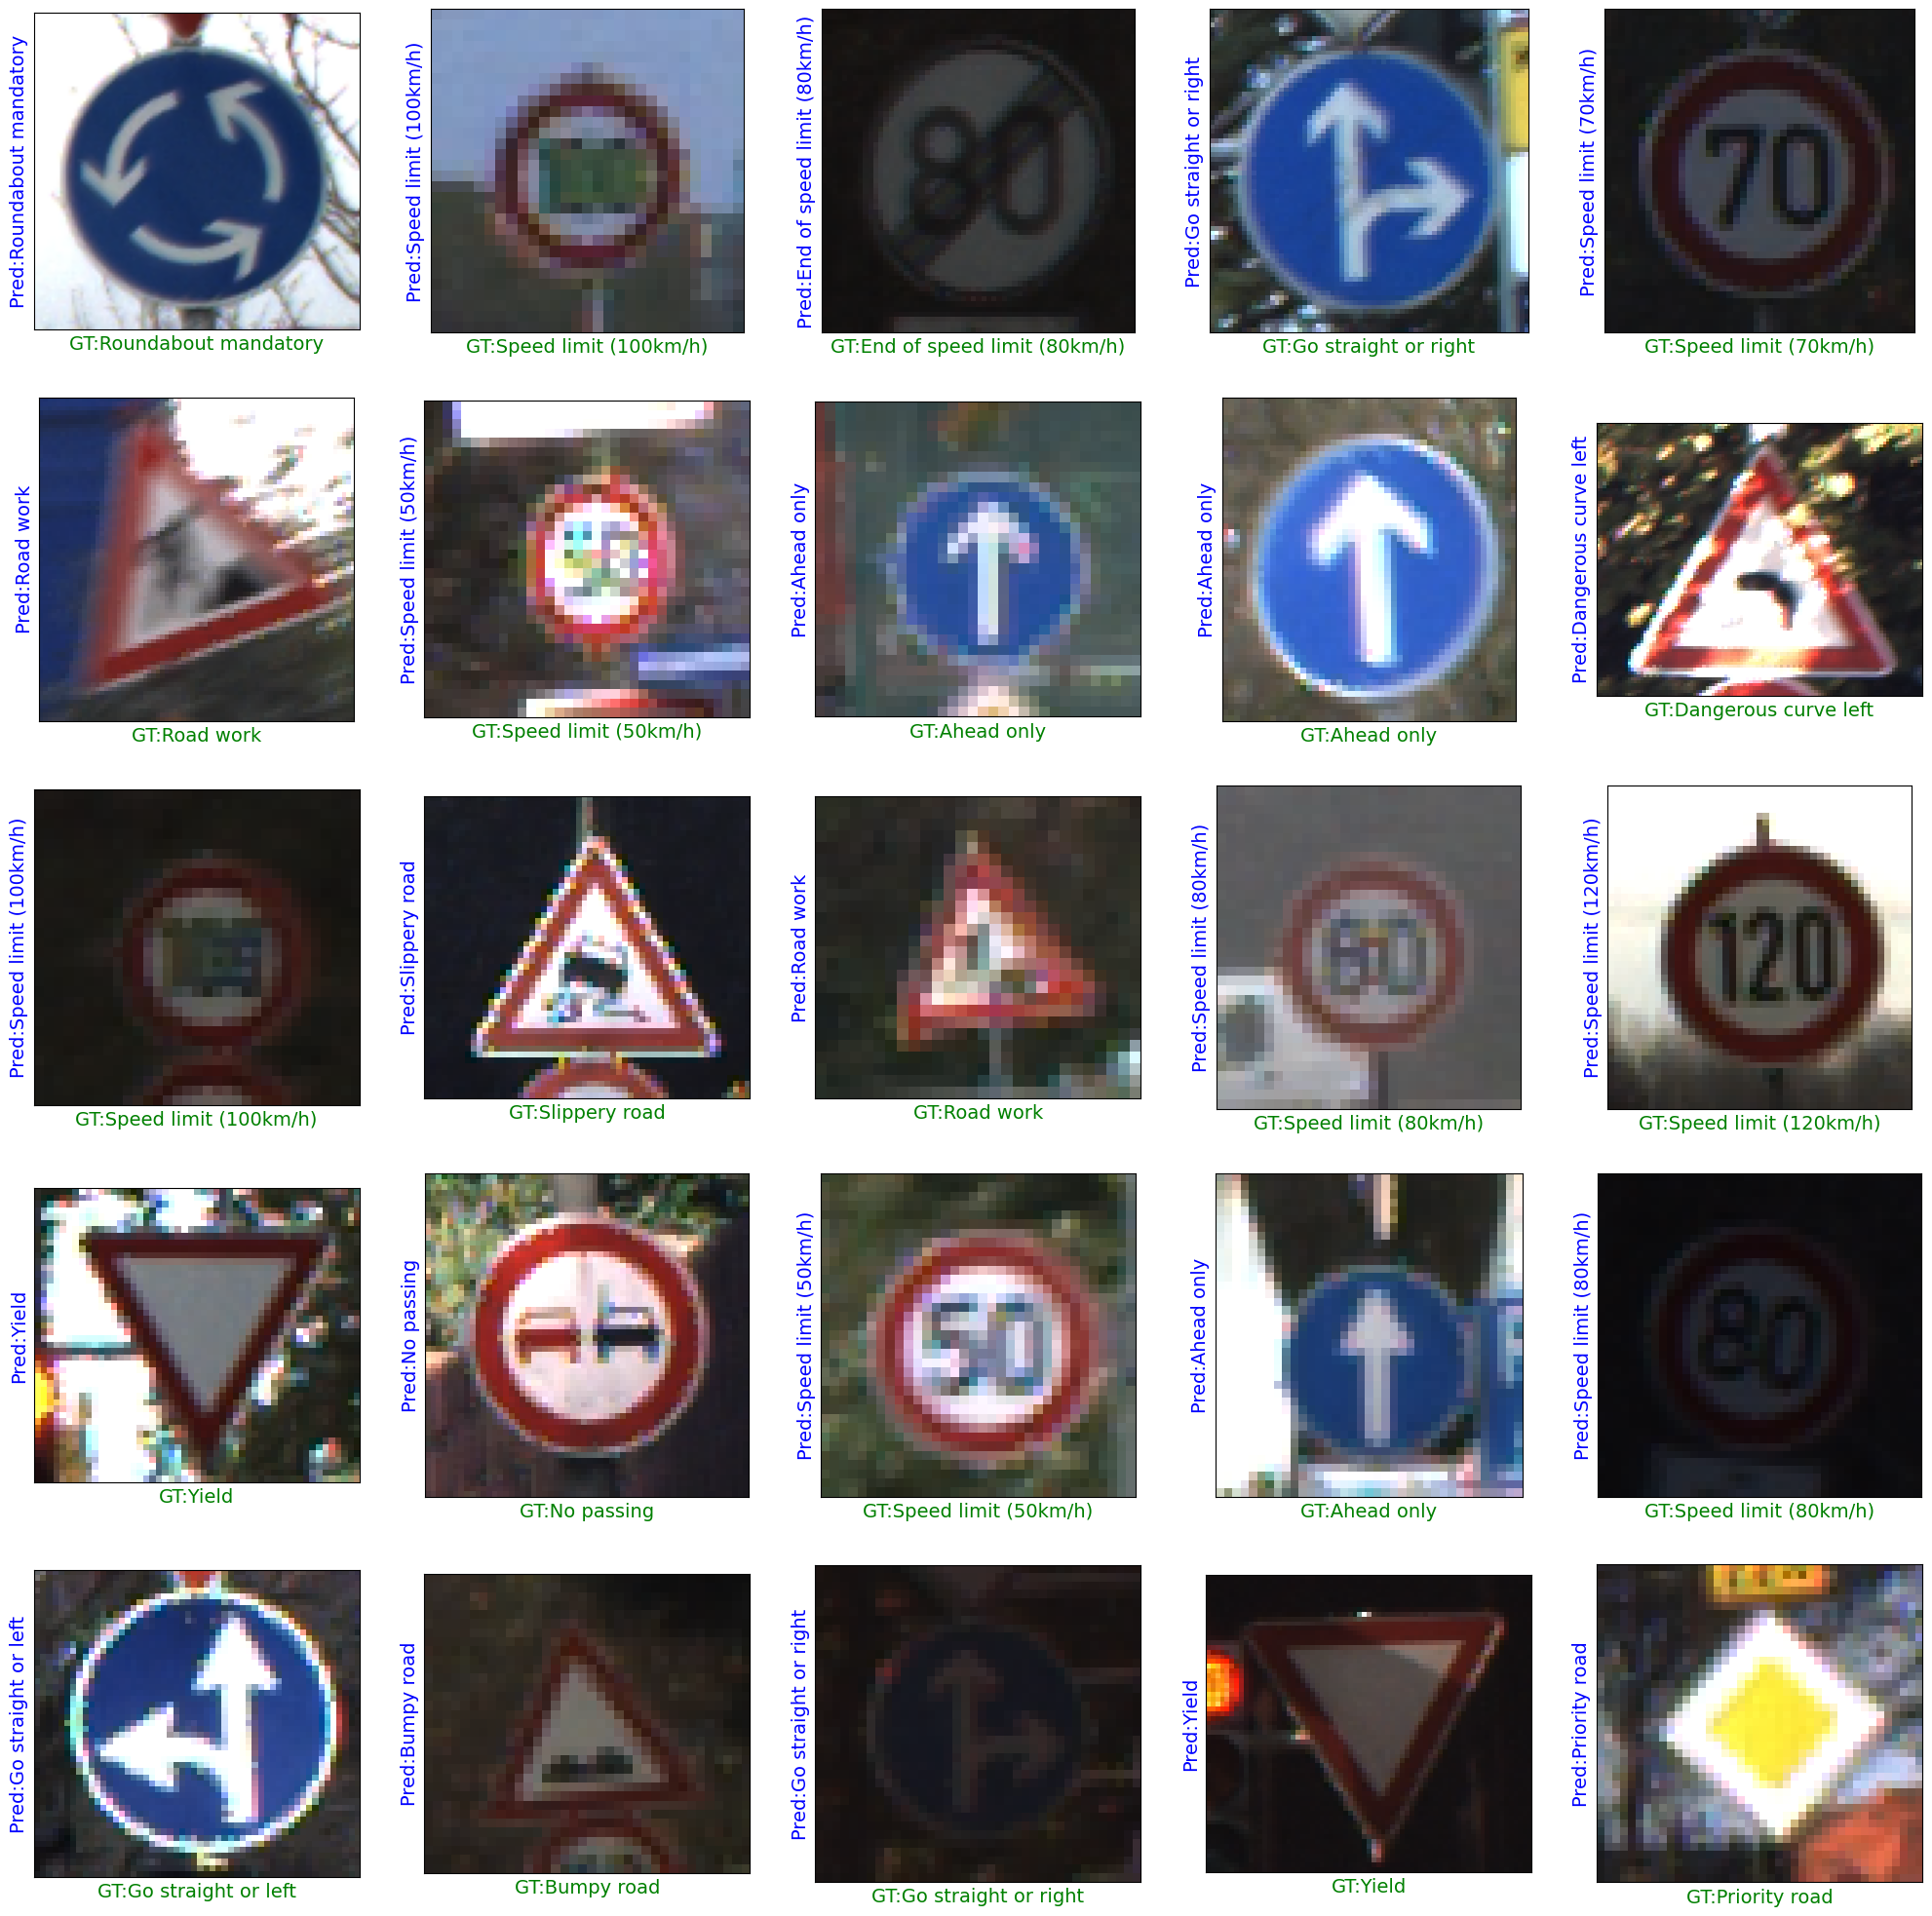

In [8]:
show_pred_with_gt(imgs=data['imgs'], preds=output, gts=data['labels'])

In [9]:
""" 
see training log:
loss is close to 0
"""
!tail -n 20 /root/yunzhi/flamingo_retrieval/retrieval/work_dir/[2024-01-10][22:54:19]PID:64834.log

2024-01-11 06:37:27.622 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:230|409] Dataset: GTSRB, Loss: 8.940696716308594e-07
2024-01-11 06:37:34.273 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:240|409] Dataset: GTSRB, Loss: 6.109476089477539e-07
2024-01-11 06:37:40.628 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:250|409] Dataset: GTSRB, Loss: 6.966292858123779e-07
2024-01-11 06:37:47.428 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:260|409] Dataset: GTSRB, Loss: 2.9616057872772217e-07
2024-01-11 06:37:54.189 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:270|409] Dataset: GTSRB, Loss: 7.636845111846924e-07
2024-01-11 06:38:01.352 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:28

In [ ]:
import sentence_transformers
output[14],data['labels'][1]